# 캐글 - Home Credit Default Risk

## https://www.kaggle.com/competitions/home-credit-default-risk

## 대출금 상환 여부 예측

- 누구에게 돈을 빌려줄 것인가?
- classification

### 데이터 설명

#### train, test 데이터

칼럼명 | 설명
-|-
SK_ID_CURR|유니크한 아이디
TARGET|타겟값(0: 정상 상환, 1: 연체 혹은 문제가 생긴 경우)
CODE_GENDER|성별(0: 여성, 1: 남성)
FLAG_OWN_CAR|차 보유 여부(0: 없음, 1: 있음)
FLAG_OWN_REALTY|주택 혹은 아파트 보유 여부(0: 없음, 1: 있음)
CNT_CHILDREN|자녀 수
AMT_INCOME_TOTAL|수입
AMT_CREDIT|대출금액
AMT_ANNUITY|1달마다 갚아야 하는 금액
NAME_TYPE_SUITE|대출신청을 할 때 누가 동행했는지
NAME_INCOME_TYPE|직업 종류
NAME_EDUCATION_TYPE|학위
NAME_HOUSING_TYPE|주거 상황
REGION_POPULATION_RELATIVE|지역의 인구
DAYS_BIRTH|나이
DAYS_EMPLOYED|언제 취업했는지(365243는 결측치)
DAYS_ID_PUBLISH|고객이 대출을 신청한 ID 문서를 변경한 날짜
OWN_CAR_AGE|보유한 차의 나이
CNT_FAM_MEMBERS|가족 수
HOUR_APPR_PROCESS_START|언제 대출신청을 했는지 시간
ORGANIZATION_TYPE|일하는 조직의 종류
EXT_SOURCE_1|외부 데이터1로부터 신용점수
EXT_SOURCE_2|외부 데이터2로부터 신용점수
EXT_SOURCE_3|외부 데이터3로부터 신용점수
DAYS_LAST_PHONE_CHANGE|마지막 핸드폰을 바꾼 시기
AMT_REQ_CREDIT_BUREAU_YEAR|신청 전 1년간 신용평가기관에 해당 사람에 대한 신용정보를 조회한 개수

#### loan_before 데이터

칼럼명 | 설명
-|-
SK_ID_CURR|유니크한 아이디
DAYS_CREDIT|해당 대출이 home credit으로부터 받은 대출보다 며칠 이전에 일어났는지
CNT_CREDIT_PROLONG|대출 연장을 몇 번 했는지
AMT_CREDIT_SUM|대출금액
CREDIT_TYPE|대출 유형

# 대출금 상환 여부 예측 프로젝트 설명

## 1. 데이터 소개 및 분석 동기

### (1) 데이터 소개

- Home Credit 기업 내부 데이터
- 1. 채무자의 인적 정보(나이, 성별, 사는 지역 등)
- 2. 대출에 대한 상세 정보(대출금액, 대출종류, 기간 등)
- 3. 채무자가 성공적으로 대출했는지에 대한 여부

### (2) 분석 설계

- 1. 모델링
- 2. 모델링에 따른 피처들의 영향력 확인
- 3. 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계 확인

## 2. 프로젝트 개발 환경

- 언어: Python
- 데이터 출처: Kaggle의 Home Credit Default Risk 데이터
- 활용 도메인 지식: 금융 데이터
- 분석 동기: 대출 상환 여부를 결정짓는 요인을 분석하고 그에 따른 대출 플랜 제안

## 3. 모델링

- AMT_CREDIT_TO_ANNUITY_RATIO: 총 대출 금액이 한달마다 갚아야 하는 금액의 12배 ~ 20배까지 일 때는 비교적 상환을 못함. 반면, 35배 이상부터는 상환을 잘 함
- DAYS_EMPLOYED: 취업한지 오래될수록 대출을 상환할 확률 상승. 특이점: 대출일 기준 9000일보다 이전에 취업을 했을 때 대출상환 능력이 급격히 상승
- DAYS_CREDIT: DAYS_CREDIT 변수는 이전에 대출을 진행했을 시에 이전과 현재 대출일간의 차이의 평균. DAYS_CREDIT은 -3000일부터 -2000일까지는 대출을 상환할 확률이 상승하며, 이후부턴 하락하는 비선형성을 보임
- DAYS_LAST_PHONE_CHANGE: 핸드폰을 오래 전에 바꾸었을수록 대출을 상환할 가능성 상승

## 4. 분석 결과

- Q. 대출 상환 여부 영향 요소
- A. 상환 여부 영향 상위 요소 5
    1. AMT_CREDIT_TO_ANNUITY_RATIO: 대출 금액 대비 월별 상환 금액의 비율
    2. DAYS_EMPLOYED: 취업한 시기
    3. DAYS_CREDIT: 다른 대출을 받은 시기
    4. DAYS_LAST_PHONE_CHANGE: 핸드폰을 바꾼 시기
    5. DAYS_BIRTH: 태어난 시기

## 5. 프로젝트 기술 스택

- 사용 모델: Xgboost
- 모델 사용 이유
    1. treeshap value를 활용하기 위해 tree형 모델 선택
    2. tree형 모델 중 속도가 빠르고, 평균적으로 높은 성능을 유지하는 Xgboost 선택

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
lb = pd.read_csv('loan_before.csv')

In [3]:
print(train.columns)
print()
print(test.columns)
print()
print(lb.columns)

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOUR

# 1. 동기 및 문제정의

<strong>동기</strong><br>
<strong>질문1</strong> : 어떤 요소가 대출금 상환 여부에 큰 영향을 줄까? <br>
<strong>질문2</strong> : 그 요소들이 상환 여부에 어떤 영향을 줄까?

# 2. 활용 데이터 출처

- 캐글의 Home Credit Default Risk 데이터
- 대출 받은 사람의 인적정보(나이, 성별, 사는 지역 등) 및 결과

# 3. 방법론

## 3.1 분석과정

- 이 질문에 대한 해답을 얻기 위해서 해석가능한 머신러닝(xAI)을 활용

<strong>프로세스</strong><br>
1단계: feature engineering을 함<br>
2단계: 머신러닝 모델을 만듦<br>
3단계: shap value를 통해 어떤 변수가 가장 큰 영향을 주는지 확인<br>
4단계: 영향을 많이 주는 5개의 변수와 대출금 상환 여부와의 관계 확인<br>

## 3.2 feature engineering

- AMT_CREDIT에서 AMT_ANNUITY를 나누어 해당 사람이 몇 개월에 걸쳐 돈을 갚아야 하는지 새로운 파생변수 생성

In [4]:
train['AMT_CREDIT_TO_ANNUITY_RATIO'] = train['AMT_CREDIT'] / train['AMT_ANNUITY']
test['AMT_CREDIT_TO_ANNUITY_RATIO'] = test['AMT_CREDIT'] / test['AMT_ANNUITY']

- lb(이전에 대출한 정보가 기록된 데이터)를 활용해 변수 생성


1. groupby 후 평균(사람id로 묶은 후 각 변수를 평균을 냄)
    - AMT_CREDIT_SUM(이전 대출의 금액)
    - DAYS_CREDIT(train, test로부터 며칠 전에 이전 대출을 진행했는지)
    - CNT_CREDIT_PROLONG(대출연장을 몇 번 했는지)
   
2. groupby 후 갯수(사람 id별로의 빈도수, 해당 사람이 이전에 대출을 몇 번 진행했는지)

In [5]:
# 특정 사람이 이전에 받은 대출 금액의 평균을 낸 후 reset_index()를 이용해 데이터프레임화

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(), 
                 on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].mean().reset_index(),
               on = 'SK_ID_CURR', how = 'left')

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),
                on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].mean().reset_index(),
               on = 'SK_ID_CURR', how = 'left')

train = pd.merge(train, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),
                on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR'])['CNT_CREDIT_PROLONG'].mean().reset_index(),
               on = 'SK_ID_CURR', how = 'left')

In [6]:
# lb 데이터에 SK_ID_CURR 칼럼의 동일 데이터가 몇 개 존재하는지 확인
## == 특정 사람이 이전에 몇 번 대출 받았는지

train = pd.merge(train, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0: 'count'}),
                on = 'SK_ID_CURR', how = 'left')
test = pd.merge(test, lb.groupby(['SK_ID_CURR']).size().reset_index().rename(columns = {0 : 'count'}),
               on = 'SK_ID_CURR', how = 'left')

- 해당 프로젝트의 목적은 모델 해석이기 때문에 이에 방해를 주는 변수는 전부 삭제

#### 제거한 변수 목록

- CODE_GENDER: 범주형 변수
- FLAG_OWN_CAR: 범주형 변수
- NAME_TYPE_SUITE: 범주형 변수
- NAME_INCOME_TYPE: 범주형 변수
- NAME_EDUCATION_TYPE: 범주형 변수
- NAME_HOUSING_TYPE: 범주형 변수
- ORGANIZATION_TYPE: 범주형 변수
- EXT_SOURCE_1: 변수의 의미를 정확히 모름
- EXT_SOURCE_2: 변수의 의미를 정확히 모름
- EXT_SOURCE_3: 변수의 의미를 정확히 모름

In [7]:
del_list = ['CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
           'NAME_EDUCATION_TYPE', 'NAME_HOUSING_TYPE', 'ORGANIZATION_TYPE',
           'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [8]:
train = train.drop(del_list, axis = 1)
test = test.drop(del_list, axis = 1)

In [9]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

## 3.3 모델링 - 대출 상환 여부를 예측하는 모델 만들기

- 해당 기법을 사용한 이유는?

- 모델링을 하기 전, 서로 상관 관계가 높은 input 변수 삭제
    - input변수가 높은 상관성을 띌 때 shap value는 제대로 된 설명력을 발휘하지 못함

In [10]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
            'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
            'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
            'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
            'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

In [11]:
corr = train[input_var].corr()
corr.style.background_gradient(cmap = 'coolwarm')

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count
FLAG_OWN_REALTY,1.000000,0.008244,0.003243,-0.042446,-0.001448,0.010826,-0.110930,-0.015164,0.004217,0.019393,0.014595,-0.105580,0.026066,0.090058,-0.083920,-0.002745,0.000174,-0.009790,0.008414
CNT_CHILDREN,0.008244,1.000000,0.029879,0.006465,0.023275,-0.033326,0.332123,0.068807,-0.029581,-0.010951,0.883051,-0.009661,-0.006102,-0.036431,-0.022026,0.035864,0.026285,-0.012065,0.002649
AMT_INCOME_TOTAL,0.003243,0.029879,1.000000,0.366717,0.441573,0.185047,0.066875,-0.041696,0.029519,-0.126551,0.029342,0.092505,-0.040823,0.031593,0.077303,0.241929,-0.013266,0.016117,0.116635
AMT_CREDIT,-0.042446,0.006465,0.366717,1.000000,0.770938,0.092177,-0.047089,-0.085049,0.000988,-0.111244,0.066847,0.047472,-0.070924,-0.037907,0.656337,0.135435,-0.068411,-0.000384,0.046902
AMT_ANNUITY,-0.001448,0.023275,0.441573,0.770938,1.000000,0.127204,0.017106,-0.048381,0.013662,-0.108185,0.073912,0.047113,-0.058709,0.000270,0.111694,0.128144,-0.052613,-0.005724,0.013588
REGION_POPULATION_RELATIVE,0.010826,-0.033326,0.185047,0.092177,0.127204,1.000000,-0.023276,0.013870,0.000946,-0.088270,-0.025638,0.182730,-0.051167,0.015725,0.003524,0.077984,-0.010819,0.003701,-0.034289
DAYS_BIRTH,-0.110930,0.332123,0.066875,-0.047089,0.017106,-0.023276,1.000000,0.349373,0.266852,-0.015877,0.283729,0.087200,0.080317,-0.073904,-0.097736,0.053205,0.201829,0.028239,-0.063004
DAYS_EMPLOYED,-0.015164,0.068807,-0.041696,-0.085049,-0.048381,0.013870,0.349373,1.000000,0.093421,0.014016,0.032736,0.003502,0.144221,0.003833,-0.087176,-0.018131,0.160521,0.000124,-0.148704
DAYS_ID_PUBLISH,0.004217,-0.029581,0.029519,0.000988,0.013662,0.000946,0.266852,0.093421,1.000000,0.001141,-0.025311,0.029700,0.089952,-0.039895,-0.020280,0.033384,0.188471,0.022736,-0.100673
OWN_CAR_AGE,0.019393,-0.010951,-0.126551,-0.111244,-0.108185,-0.088270,-0.015877,0.014016,0.001141,1.000000,-0.039362,-0.082672,0.013561,-0.025423,-0.059224,-0.094781,-0.006665,0.011323,-0.025711


- 위 상관관계 표에서 빨강색이 진할수록 상관성이 높음


- 높은 상관성을 띄는 변수
- CNT_FAM_MEMBERS, CNT_CHILDREN
- AMT_CREDIT_TO_ANNUITY_RATIO, AMT_CREDIT
- AMT_ANNUITY, AMT_CREDIT

In [12]:
print(train['CNT_FAM_MEMBERS'].corr(train['TARGET']))
print(train['CNT_CHILDREN'].corr(train['TARGET']))

0.018876651698723743
0.025357359317615805


- CNT_FAM_MEMBERS와 CNT_CHILDREN 중 타겟값과 높은 결정계수를 가진 변수는 CNT_CHILDREN이므로, CNT_FAM_MEMBERS를 삭제함

In [13]:
del train['CNT_FAM_MEMBERS']
del test['CNT_FAM_MEMBERS']

In [14]:
print(train['AMT_CREDIT_TO_ANNUITY_RATIO'].corr(train['TARGET']))
print(train['AMT_CREDIT'].corr(train['TARGET']))

-0.02474028833519017
-0.022558430849347604


- AMT_CREDIT_TO_ANNUITY_RATIO와 AMT_CREDIT 중 타겟값과 높은 결정계수를 가진 변수는 AMT_CREDIT_TO_ANNUITY_RATIO이므로, AMT_CREDIT를 삭제함

In [15]:
del train['AMT_CREDIT']
del test['AMT_CREDIT']

In [16]:
train.columns

Index(['SK_ID_CURR', 'TARGET', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO',
       'AMT_CREDIT_SUM', 'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count'],
      dtype='object')

In [18]:
input_var = ['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY',
            'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH',
            'OWN_CAR_AGE', 'HOUR_APPR_PROCESS_START', 'DAYS_LAST_PHONE_CHANGE',
            'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_CREDIT_TO_ANNUITY_RATIO', 'AMT_CREDIT_SUM',
            'DAYS_CREDIT', 'CNT_CREDIT_PROLONG', 'count']

- xgboost를 활용해 모델링 진행
- 이유: shap value를 활용하기 위해선 모델이 랜덤포레스트 형태의 tree형 모델이어야 함. 이 중에서 xgboost가 속도가 빠르면서 높은 성능을 유지하므로 이를 선택

In [19]:
from xgboost import XGBClassifier

In [20]:
model = XGBClassifier(n_estimators = 100, learning_rate = 0.1)
model.fit(train[input_var], train['TARGET'])

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:51:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

## 3.4 shap value 활용

- 영향력 확인: shape value를 통해 어떤 요소가 상환 여부에 큰 영향을 주는지 확인

In [21]:
import shap

In [22]:
shap_values = shap.TreeExplainer(model).shap_values(train[input_var])

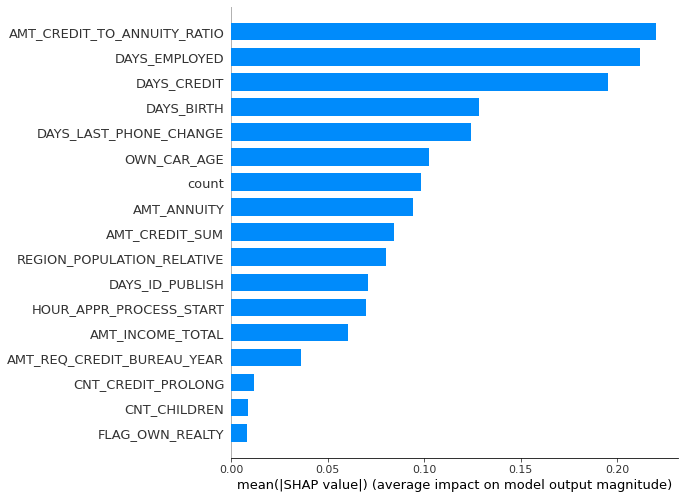

In [23]:
shap.summary_plot(shap_values, train[input_var], plot_type = 'bar')

- 시각화 결과, 타겟값에 가장 큰 영향을 미치는 상위 5가지 변수는 다음과 같다

    1. AMT_CREDIT_TO_ANNUITY_RATIO
    2. DAYS_EMPLOYED
    3. DAYS_CREDIT
    4. DAYS_BIRTY
    5. DAYS_LAST_PHONE_CHANGE

## 3.5 영향을 많이 주는 5개의 변수와 상환 여부와의 관계 확인

### 1. AMT_CREDIT_TO_ANNUITY_RATIO

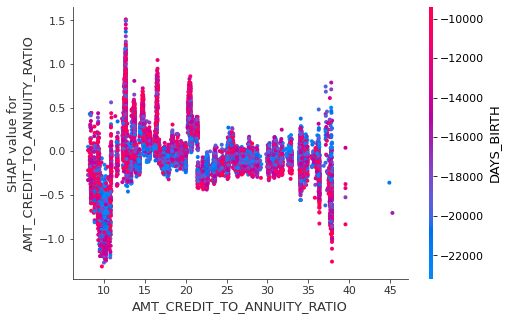

In [24]:
shap.dependence_plot('AMT_CREDIT_TO_ANNUITY_RATIO', shap_values, train[input_var])

- 대출 상환 기간이 12개월에서 20개월 사이일 때 비교적 상환을 잘 못함
- 반면 12개월 이하, 20개월 이상일 때는 상환을 비교적 잘 함

### 2. DAYS_EMPLOYED

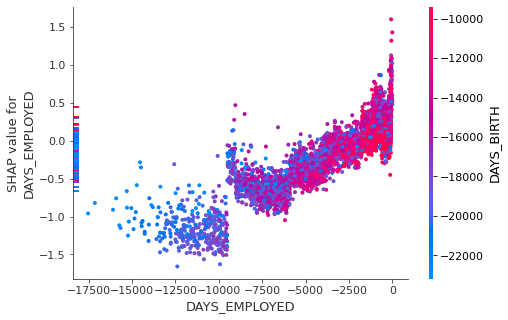

In [25]:
shap.dependence_plot('DAYS_EMPLOYED', shap_values, train[input_var])

- 취업한 지 오래되면 오래될수록 대출상환확률이 올라감
- 대출일 기준 9000일보다 오래 전에 취업했을 때 대출상환능력이 급상승

### 3. DAYS_CREDIT

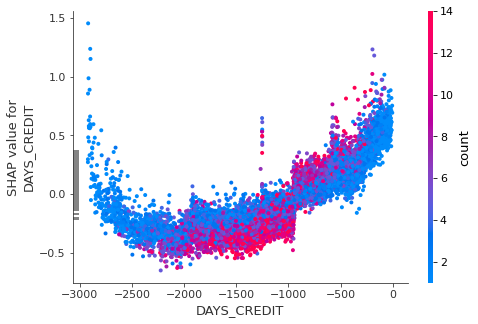

In [26]:
shap.dependence_plot('DAYS_CREDIT', shap_values, train[input_var])

- DAYS_CREDIT은 -3000일부터 -2000일까지는 대출상환능력이 상승
- 그 이후부턴 하락

### 4. DAYS_BIRTY

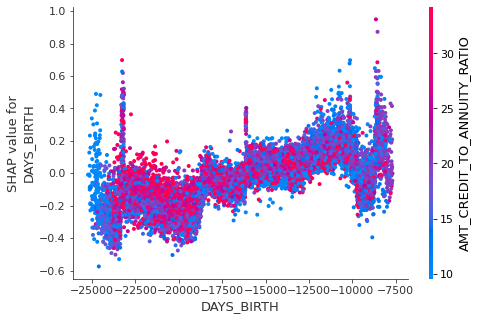

In [27]:
shap.dependence_plot('DAYS_BIRTH', shap_values, train[input_var])

- 나이가 많으면 많을수록, 대출상환을 잘 하는 경향이 있음

### 5. DAYS_LAST_PHONE_CHANGE

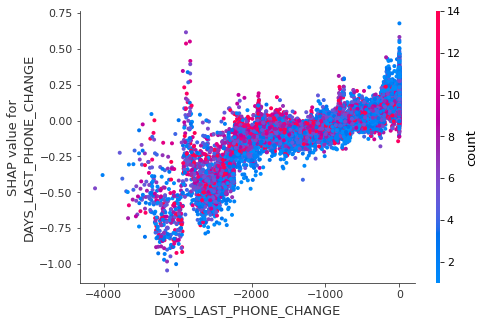

In [29]:
shap.dependence_plot('DAYS_LAST_PHONE_CHANGE', shap_values, train[input_var])

- 핸드폰을 오래 전에 바꾸었을수록 대출금을 상환할 가능성이 높아짐

# 4. 결론

1. 대출 상환 기간이 상환여부에 가장 큰 영향을 줌. 해당 영향은 비선형적 관계.(영향이 크다고 해서 인과관계가 있다고 단정짓긴 어려움)
2. 주택 보유 여부와 자식의 수는 대출 상환능력에 큰 영향을 미치지 않음
3. 최근에 취업했을수록, 최근에 대출을 받았을수록, 최근에 핸드폰을 바꿨을수록, 나이가 어릴수록 대출금 상환 가능성이 낮음(DAYS_EMPLOYED, DAYS_CREDIT, DAYS_LAST_PHONE_CHANGE, DAYS_BIRTH가 클수록 대출금 상환 가능성이 낮음)

## 4.1 마무리 시각화

In [32]:
train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']     # 상위 25% 이내

0        False
1        False
2        False
3        False
4        False
         ...  
19995    False
19996    False
19997     True
19998    False
19999    False
Name: DAYS_EMPLOYED, Length: 20000, dtype: bool

In [33]:
# 상위 25% 이내

group1 = train.loc[(train['DAYS_EMPLOYED'].quantile(0.75) < train['DAYS_EMPLOYED']) &
                  (train['DAYS_CREDIT'].quantile(0.75) < train['DAYS_CREDIT']) &
                  (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.75) < train['DAYS_LAST_PHONE_CHANGE']) &
                  (train['DAYS_BIRTH'].quantile(0.75) < train['DAYS_BIRTH'])]

In [34]:
# 하위 25%보다 작은 경우

group2 = train.loc[(train['DAYS_EMPLOYED'].quantile(0.25) > train['DAYS_EMPLOYED']) &
                  (train['DAYS_CREDIT'].quantile(0.25) > train['DAYS_CREDIT']) &
                  (train['DAYS_LAST_PHONE_CHANGE'].quantile(0.25) > train['DAYS_LAST_PHONE_CHANGE']) &
                  (train['DAYS_BIRTH'].quantile(0.25) > train['DAYS_BIRTH'])]

In [36]:
group1['group'] = 1
group2['group'] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [37]:
full = pd.concat([group1, group2], axis = 0)
full

,SK_ID_CURR,TARGET,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,OWN_CAR_AGE,HOUR_APPR_PROCESS_START,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_YEAR,AMT_CREDIT_TO_ANNUITY_RATIO,AMT_CREDIT_SUM,DAYS_CREDIT,CNT_CREDIT_PROLONG,count,group
19,148243,0,1,0,157500.0,29470.5,0.006305,-9946,-694.0,-430,NaN,9,0.0,7.0,20.787296,670500.000000,-291.000000,0.0,1.0,1
97,449339,0,1,0,139500.0,22122.0,0.018801,-8723,-263.0,-1404,13.0,8,-256.0,1.0,24.410090,402856.500000,-449.666667,0.0,6.0,1
104,244014,0,1,0,103500.0,14715.0,0.007020,-12172,-634.0,-2351,NaN,14,-5.0,0.0,31.854128,205537.500000,-345.500000,0.0,2.0,1
130,213561,0,1,2,220500.0,17311.5,0.016612,-10021,-180.0,-2699,20.0,12,-118.0,0.0,26.254224,90000.000000,-204.000000,0.0,1.0,1
187,132571,0,1,0,112500.0,18927.0,0.018029,-9361,-631.0,-2038,NaN,6,-118.0,2.0,21.305516,119263.500000,-374.250000,0.0,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18513,350380,0,1,0,157500.0,30645.0,0.046220,-20285,-6106.0,-3830,9.0,17,-2197.0,3.0,25.110132,104065.200000,-1597.500000,0.0,2.0,0
18617,169817,0,1,0,270000.0,30640.5,0.024610,-20163,-8222.0,-3667,NaN,12,-1812.0,3.0,27.840799,105273.125000,-1713.888889,0.0,18.0,0
19773,357658,0,0,0,135000.0,22216.5,0.007305,-19808,-3285.0,-3307,NaN,8,-2459.0,0.0,23.463642,443457.500000,-1568.333333,0.0,9.0,0
19783,255934,0,0,0,382500.0,24403.5,0.025164,-20340,-6993.0,-3798,2.0,16,-1692.0,1.0,34.020284,157494.353226,-1819.451613,0.0,31.0,0


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:xlabel='group', ylabel='TARGET'>

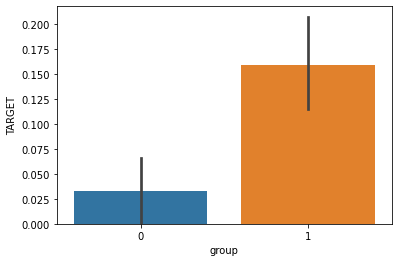

In [38]:
sns.barplot('group', 'TARGET', data = full)